## Loading the curated citations dataset and do processing

In [1]:
# All imports
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scripts.const import CITATION_TEMPLATES

import findspark
findspark.init('/Users/harshdeep/Downloads/spark-1.6.0-bin-hadoop2.6/')
from pyspark import SparkContext, SQLContext


import warnings
warnings.filterwarnings("ignore")

### Load the citations (extracted) parquet file with 21 million citations

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
all_citations = sqlContext.read.parquet('./citations_separated.parquet/')

In [4]:
# Get citation count for all the 25 citations which can be parsed
citation_count = all_citations.groupby('type_of_citation').count().toPandas()

In [5]:
citation_count['type_of_citation'].unique()

array([u'cite journal', u'cite dvd notes', u'cite thesis',
       u'cite episode', u'cite encyclopedia', u'cite newsgroup',
       u'cite arxiv', u'cite web', u'cite mailing list', u'cite av media',
       u'citation', u'cite conference', u'cite news', u'cite report',
       u'cite av media notes', u'cite press release', u'cite serial',
       u'cite map', u'cite techreport', u'cite podcast', u'cite book',
       u'cite interview', u'cite speech', u'cite sign'], dtype=object)

### Get the top 300 templates (according to DLAB) and compare it with the number of citations we have got

In [6]:
top300_templates = pd.read_csv('top300_templates.csv')

In [7]:
# Only consider the templates which can be parsed by mwparserfromhell
parseable_template_count = top300_templates.loc[top300_templates['template'].isin(CITATION_TEMPLATES)]

In [8]:
merged_counts = pd.merge(
    parseable_template_count, citation_count,
    left_on='template', right_on='type_of_citation', how='inner'
).drop('template', axis=1)

merged_counts.columns = ['dlab_count', 'type_of_citation', 'curated_count']

In [9]:
merged_counts['bigger_than'] = merged_counts['curated_count'] - merged_counts['dlab_count']
merged_counts

,dlab_count,type_of_citation,curated_count,bigger_than
0,13340076,cite web,15471265,2131189
1,4003325,cite news,4322391,319066
2,1765330,cite book,2696638,931308
3,1413205,cite journal,1948740,535535
4,304742,citation,522202,217460
5,62177,cite press release,66128,3951
6,39439,cite episode,43985,4546
7,34989,cite map,38495,3506
8,33637,cite encyclopedia,45954,12317
9,32269,cite report,37653,5384


In [10]:
# Load all csv files and add them into one dataframe
files = glob.glob('citations_ids.csv/part-*')
citation_dataframes = [pd.read_csv(f, header=None, sep=',') for f in files]
citation_with_ids = pd.concat(citation_dataframes, ignore_index=True)

In [11]:
print(citation_with_ids.shape)
total_citations = citation_with_ids.shape[0]

(3355479, 5)


In [12]:
citation_with_ids.head()

,0,1,2,3,4
0,1831197,Ray Sharkey,Fatal Deceit,{ISSN=0093-7673},"[{last=Gliatto, first=Tom}]"
1,1831220,Protamine sulfate,WHO Model Formulary 2008,{ISBN=9789241547659},NaN
2,1831220,Protamine sulfate,Protamine sulfate as an effective alternative ...,"{PMID=2786000, DOI=10.1016/0166-0934(89)90132-8}","[{last=Kenneth Cornetta}, {last=W.French Ander..."
3,1831220,Protamine sulfate,Protamine sulfate enhances lipid-mediated gene...,"{PMID=9349433, DOI=10.1038/sj.gt.3300484}","[{last=Sorgi, first=FL}, {last=Bhattacharya, S..."
4,1831220,Protamine sulfate,Successful cardiopulmonary bypass in diabetics...,"{PMID=6743419, PMC=481594, DOI=10.1136/hrt.52....","[{last=Walker, first=WS}, {last=Reid, KG}, {la..."


In [13]:
citation_with_ids.columns = [
    'id', 'title_of_page', 'title_of_citation', 'id_list', 'authors',
    # 'publisher_place', 'type_of_citation', 'publisher_name'
]

In [14]:
# Percentage of values present for title of page, title of citation and authors
(citation_with_ids.count() * 100) / total_citations

id                   100.000000
title_of_page         99.999940
title_of_citation     99.898465
id_list              100.000000
authors               92.911891
dtype: float64

In [15]:
# citation_with_ids.groupby('type_of_citation').size()

In [16]:
# Formulate a structure for the ID_List in which we can do something meaningful
citation_with_ids['id_list'] = citation_with_ids['id_list'].apply(
    lambda x: list(item.split('=') for item in x.replace('{','').replace('}','').replace(' ', '').split(','))
)

In [17]:
# Get the kinds of ids associated with each tuple
kinds_of_ids = set()
def update_ids(x):
    for item in x:
        kinds_of_ids.add(item[0])

_ = citation_with_ids['id_list'].apply(lambda x: update_ids(x))

# Add the columns with NoneType in the previous DF
for id_ in kinds_of_ids:
    citation_with_ids[id_] = None

In [18]:
print('Total kind of Citation IDs: {}'.format(len(kinds_of_ids)))

Total kind of Citation IDs: 52


In [19]:
# Set the value of identifiers for each column, for e.g. DOI, ISBN etc.
def set_citation_val(x):
    for item in x['id_list']:
        citation_with_ids.at[x.name, item[0]] = item[1] if len(item) >= 2 else None

_ = citation_with_ids.apply(lambda x: set_citation_val(x), axis=1)

In [20]:
citation_with_ids.head()

,id,title_of_page,title_of_citation,id_list,authors,DOI,ISBN,JFM,1997),ARXIV,...,+david+w.,5-79-051006-X,5-7905-1008-6,info:pmid/25772496&rft.eissn,+xin,cribb,No.3(Summer,MR,ZBL,PMID
0,1831197,Ray Sharkey,Fatal Deceit,"[[ISSN, 0093-7673]]","[{last=Gliatto, first=Tom}]",None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,1831220,Protamine sulfate,WHO Model Formulary 2008,"[[ISBN, 9789241547659]]",NaN,None,9789241547659,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,1831220,Protamine sulfate,Protamine sulfate as an effective alternative ...,"[[PMID, 2786000], [DOI, 10.1016/0166-0934(89)9...","[{last=Kenneth Cornetta}, {last=W.French Ander...",10.1016/0166-0934(89)90132-8,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2786000
3,1831220,Protamine sulfate,Protamine sulfate enhances lipid-mediated gene...,"[[PMID, 9349433], [DOI, 10.1038/sj.gt.3300484]]","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",10.1038/sj.gt.3300484,None,None,None,None,...,None,None,None,None,None,None,None,None,None,9349433
4,1831220,Protamine sulfate,Successful cardiopulmonary bypass in diabetics...,"[[PMID, 6743419], [PMC, 481594], [DOI, 10.1136...","[{last=Walker, first=WS}, {last=Reid, KG}, {la...",10.1136/hrt.52.1.112,None,None,None,None,...,None,None,None,None,None,None,None,None,None,6743419


### How do the identifiers appear with each other?

* Do we have citations with a lot of two identifiers?

In [21]:
identifiers_existing = citation_with_ids[['DOI', 'ISBN', 'ISSN', 'PMC', 'PMID']].notnull()

In [22]:
identifiers_existing.head()

,DOI,ISBN,ISSN,PMC,PMID
0,False,False,True,False,False
1,False,True,False,False,False
2,True,False,False,False,True
3,True,False,False,False,True
4,True,False,False,True,True


In [23]:
all_columns = identifiers_existing.columns
frequency_citation = dict()

def get_frequency_of_identifiers_appearing(x):
    available_citation_types = tuple([column for column in all_columns if x[column]])
    frequency_citation.setdefault(available_citation_types, 0)
    frequency_citation[available_citation_types] += 1

_ = identifiers_existing.apply(lambda x: get_frequency_of_identifiers_appearing(x), axis=1)

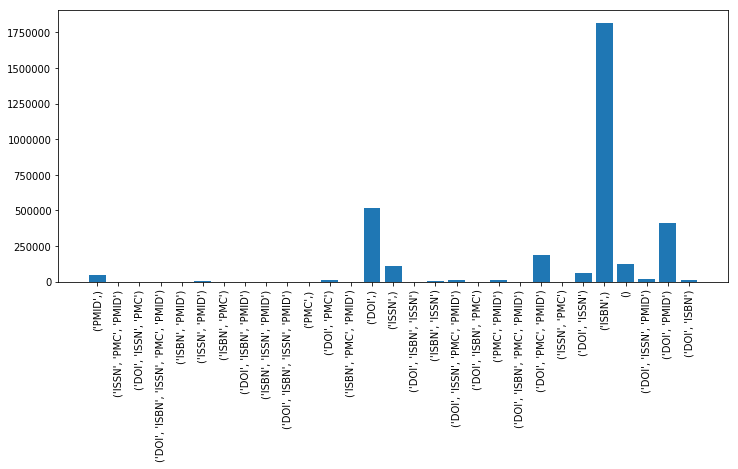

In [24]:
# Make a graph of the frequency distribution calculated above
names = list(frequency_citation.keys())
values = list(frequency_citation.values())

plt.rcParams["figure.figsize"] = (12,5)
plt.xticks(rotation=90)
plt.bar(range(len(frequency_citation)),values,tick_label=names)
plt.show()

## Loading the wikipedia dataset with identifiers

In [25]:
CITATION_WITH_IDENTIFIERS = '../Citations_with_Identifiers/enwiki.tsv.tar.gz'

wiki_en_identifiers = pd.read_csv(CITATION_WITH_IDENTIFIERS, compression='gzip', sep='\t')

In [26]:
wiki_en_identifiers.head(5)

,enwiki.tsv,page_title,rev_id,timestamp,type,id
0,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20078357
1,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0604502
2,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0003329
3,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,0708.1752
4,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20064946


In [27]:
print('Total citation identifiers for English Wikipedia: {}'.format(wiki_en_identifiers.shape[0]))

Total citation identifiers for English Wikipedia: 3794696


In [28]:
wiki_en_identifiers['type'].unique() # Labels which have unique IDSs

array(['doi', 'arxiv', 'isbn', 'pmid', 'pmc', nan], dtype=object)

In [29]:
# Remove the one with the NaN value
wiki_en_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'].notnull()]

In [30]:
# Adding a boolean to check if the citation is in other dataset - to 
wiki_en_identifiers['is_in_other_dataset'] = False

## Comparing the two datasets

The gap exists between the two datasets (3.8 mil, 3.4 mil) of about 400,000  because we are looking only at certain citation formats which can be parsed by the `mwparserfromhell`. But still we have got 95% of the citation data by looking at just mere numbers. The 5% deficit is because of the dataset used by wiki identifiers is for revision where we are using a dataset relating to a particular date.

In [31]:
gap = wiki_en_identifiers.shape[0] - total_citations

print('The total gap between between total number of wikipedias citations and our citations: {}'.format(gap))

The total gap between between total number of wikipedias citations and our citations: 439216


In [32]:
def get_citations_specific_to_type(wiki_type, curated_type):
    type_wiki_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'] == wiki_type]
    type_citations_curated = citation_with_ids[citation_with_ids[curated_type].notnull()]
    
    # Just considering the unique ones since they are a lot of duplicated DOIs
    # Maybe one citation is cited in many different pages
    number_of_identifiers_wiki = type_wiki_identifiers['id'].shape[0]
    number_of_identifiers_curated = type_citations_curated['DOI'].shape[0]
    print('The total number of unique {} wiki identifiers: {}'.format(wiki_type, number_of_identifiers_wiki))
    print('The total number of unique {} curated identifiers: {}'.format(curated_type, number_of_identifiers_curated))
    
    print('\nThe difference between wiki and curated is: {}'.format(
        number_of_identifiers_wiki - number_of_identifiers_curated)
    )
    
    return type_wiki_identifiers, type_citations_curated

### How many DOI identifiers are common?

In [33]:
doi_wiki_identifiers, doi_citations_curated = get_citations_specific_to_type('doi', 'DOI')

The total number of unique doi wiki identifiers: 1211807
The total number of unique DOI curated identifiers: 1231233

The difference between wiki and curated is: -19426


In [34]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia
doi_which_are_present = doi_wiki_identifiers['id'].isin(doi_citations_curated['DOI'])
total_number_of_doi_identifiers_in_wiki = np.sum(doi_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[doi_which_are_present.index] = doi_which_are_present.values

In [35]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        doi_citations_curated.shape[0],
        doi_wiki_identifiers.shape[0],
        total_number_of_doi_identifiers_in_wiki,
        doi_citations_curated.shape[0] - total_number_of_doi_identifiers_in_wiki,
        doi_which_are_present[~doi_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 1231233 
Total Wiki:1211807 
Curated which are in Wiki: 1049892 
Gap: 181341 -> Wiki which are not identified: 161915


### How many ISBN (also ISSN) identifiers are common?

* ISBNs are International Standard Book Numbers. They can be assigned to monographic publications, such as books, e-books and audiobooks.
* ISMNs are International Standard Music Numbers. They can be assigned to notated music (scores and sheet music) whether published in print, online or in other media.
* ISSNs are International Standard Serial Numbers. They can be assigned to periodical publications, such as magazines and journals.

In [36]:
isbn_wiki_identifiers, isbn_citations_curated = get_citations_specific_to_type('isbn', 'ISBN')

The total number of unique isbn wiki identifiers: 1740812
The total number of unique ISBN curated identifiers: 1834431

The difference between wiki and curated is: -93619


### Trying to normalize all the ISBN (also need to do for ISSN)

* So if '00-11-223344' it becomes '0011223344'

In [37]:
# Check if the wikipedia citation identifiers does not have hyphens
np.sum(isbn_wiki_identifiers['id'].apply(lambda x: '-' in x))

0

In [38]:
isbn_citations_curated['ISBN'] = isbn_citations_curated['ISBN'].apply(lambda x: x.replace('-', ''))

In [39]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia

isbn_which_are_present = isbn_wiki_identifiers['id'].isin(isbn_citations_curated['ISBN'])
total_number_of_isbn_identifiers_in_wiki = np.sum(isbn_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[isbn_which_are_present.index] = isbn_which_are_present.values

In [40]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        isbn_citations_curated.shape[0],
        isbn_wiki_identifiers.shape[0],
        total_number_of_isbn_identifiers_in_wiki,
        isbn_citations_curated.shape[0] - total_number_of_isbn_identifiers_in_wiki,
        isbn_which_are_present[~isbn_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 1834431 
Total Wiki:1740812 
Curated which are in Wiki: 1633175 
Gap: 201256 -> Wiki which are not identified: 107637


### Now time for ISSN...

In [41]:
# But the stats for this does not matter!!!
# because the hypothesis is that ISSN is contained inside ISBN - but only some of them do!
isbn_wiki_identifiers, issn_citations_curated = get_citations_specific_to_type('isbn', 'ISSN')

The total number of unique isbn wiki identifiers: 1740812
The total number of unique ISSN curated identifiers: 215823

The difference between wiki and curated is: 1524989


In [42]:
# Normalizing it again like ISBN
issn_citations_curated['ISSN'] = issn_citations_curated['ISSN'].apply(lambda x: x.replace('-', ''))

In [43]:
issn_which_are_present = issn_citations_curated['ISSN'].isin(isbn_wiki_identifiers['id'])
total_number_of_issn_identifiers_in_wiki = np.sum(issn_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[issn_which_are_present.index] = issn_which_are_present.values

In [44]:
print(
    'Stats:\nTotal Curated: {} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        issn_citations_curated.shape[0],
        total_number_of_issn_identifiers_in_wiki,
        issn_citations_curated.shape[0] - total_number_of_issn_identifiers_in_wiki,
        issn_which_are_present[~issn_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 215823 
Curated which are in Wiki: 8408 
Gap: 207415 -> Wiki which are not identified: 207415


What we can see is that ISSN exists in our `curated` dataset and only some of them of these are contained in the existing `wikipedia dataset`. Most of them do not exist and hence the hypothesis is potentially not correct. Also, some of these can be counter examples since they are magazines and music volumes which are not scientific in nature.

### How many PMID identifiers are common?

In [45]:
pmid_wiki_identifiers, pmid_citations_curated = get_citations_specific_to_type('pmid', 'PMID')

The total number of unique pmid wiki identifiers: 609848
The total number of unique PMID curated identifiers: 698628

The difference between wiki and curated is: -88780


In [46]:
# Check if curated PMIDs are contained in the already obtained dataset from Wikipedia
pmid_which_are_present = pmid_citations_curated['PMID'].isin(pmid_wiki_identifiers['id'])
total_number_of_pmid_identifiers_in_wiki = np.sum(pmid_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[pmid_which_are_present.index] = pmid_which_are_present.values

In [47]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        pmid_citations_curated.shape[0],
        pmid_wiki_identifiers.shape[0],
        total_number_of_pmid_identifiers_in_wiki,
        pmid_citations_curated.shape[0] - total_number_of_pmid_identifiers_in_wiki,
        pmid_which_are_present[~pmid_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 698628 
Total Wiki:609848 
Curated which are in Wiki: 662748 
Gap: 35880 -> Wiki which are not identified: 35880


### How many PMC identifiers are common?

In [48]:
pmc_wiki_identifiers, pmc_citations_curated = get_citations_specific_to_type('pmc', 'PMC')

The total number of unique pmc wiki identifiers: 181240
The total number of unique PMC curated identifiers: 226903

The difference between wiki and curated is: -45663


In [49]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
pmc_which_are_present = pmc_citations_curated['PMC'].isin(pmc_wiki_identifiers['id'])
total_number_of_pmc_identifiers_in_wiki = np.sum(pmc_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[pmc_which_are_present.index] = pmc_which_are_present.values

In [50]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        pmc_citations_curated.shape[0],
        pmc_wiki_identifiers.shape[0],
        total_number_of_pmc_identifiers_in_wiki,
        pmc_citations_curated.shape[0] - total_number_of_pmc_identifiers_in_wiki,
        pmc_which_are_present[~pmc_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 226903 
Total Wiki:181240 
Curated which are in Wiki: 201938 
Gap: 24965 -> Wiki which are not identified: 24965


### How many ArXiV identifiers are common?

In [51]:
arxiv_wiki_identifiers, arxiv_citations_curated = get_citations_specific_to_type('arxiv', 'ARXIV')

The total number of unique arxiv wiki identifiers: 50988
The total number of unique ARXIV curated identifiers: 47725

The difference between wiki and curated is: 3263


In [52]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
arxiv_which_are_present = arxiv_citations_curated['ARXIV'].isin(arxiv_wiki_identifiers['id'])
total_number_of_arxiv_identifiers_in_wiki = np.sum(arxiv_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[arxiv_which_are_present.index] = arxiv_which_are_present.values

In [53]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        arxiv_citations_curated.shape[0],
        arxiv_wiki_identifiers.shape[0],
        total_number_of_arxiv_identifiers_in_wiki,
        arxiv_citations_curated.shape[0] - total_number_of_arxiv_identifiers_in_wiki,
        arxiv_which_are_present[~arxiv_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 47725 
Total Wiki:50988 
Curated which are in Wiki: 40606 
Gap: 7119 -> Wiki which are not identified: 7119


## Check which citations in already existing ones are not in curated?